# Evaluation Metrics Visualization

This notebook loads an evaluation CSV (e.g., `davis_metrics.csv`, `kiba_metrics.csv`, `bind_metrics.csv`) and visualizes metrics with seaborn. You can set `metrics_file` manually or let the notebook auto-detect a suitable CSV.

In [1]:
# Imports and setup
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
BASE_DIR = Path("..")  # repo root from this notebook folder
DATA_DIR = BASE_DIR
FIG_DIR = BASE_DIR / "Evaluation_Metrics" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Figures will be saved to: {FIG_DIR.resolve()}")

Figures will be saved to: /Users/cheng.wang/Documents/GitHub/llm-drug-agent/Evaluation_Metrics/figures


In [2]:
# Auto-detect a metrics CSV if not set
candidate_files = [
    "davis_metrics.csv",
    "kiba_metrics.csv",
    "bind_metrics.csv",
]

metrics_file = None
for fname in candidate_files:
    fpath = DATA_DIR / fname
    if fpath.exists():
        metrics_file = fpath
        break

# You can override manually like:
# metrics_file = DATA_DIR / "davis_metrics.csv"

print("Detected metrics file:", metrics_file)
assert metrics_file is not None, "No metrics CSV found. Please set metrics_file to a valid path."

Detected metrics file: ../davis_metrics.csv


In [3]:
# Load data and inspect

df = pd.read_csv(metrics_file)
print(df.head())

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Identify key categorical and metric columns
cat_cols = [c for c in df.columns if c.lower() in {"model", "dataset"}]
metric_cols = [
    c for c in df.columns
    if c not in cat_cols and pd.api.types.is_numeric_dtype(df[c])
]
print("Categorical columns:", cat_cols)
print("Metric columns:", metric_cols)

assert "Model" in df.columns, "Expected a 'Model' column"
# Some files include 'Dataset' with values like Training/Validation/Test
has_dataset = "Dataset" in df.columns

# Sort models by average of a primary metric if present
primary_metric = None
for candidate in ["RMSE", "MAE", "R2", "MSE"]:
    if candidate in metric_cols:
        primary_metric = candidate
        break

if primary_metric:
    order = df.groupby("Model")[primary_metric].mean().sort_values(ascending=(primary_metric not in {"R2"})).index
else:
    order = sorted(df["Model"].unique())

print("Model plot order by", primary_metric or "appearance", ":", list(order))

           Model     Dataset      RMSE       MAE       MSE        R2
0  Random Forest    Training  0.221362  0.132025  0.049001  0.929044
1  Random Forest  Validation  0.575139  0.346981  0.330785  0.504049
2  Random Forest        Test  0.610381  0.368079  0.372565  0.478595
3            SVR    Training  0.576812  0.295331  0.332712  0.518214
4            SVR  Validation  0.616045  0.338454  0.379512  0.430992
Categorical columns: ['Model', 'Dataset']
Metric columns: ['RMSE', 'MAE', 'MSE', 'R2']
Model plot order by RMSE : ['MLP', 'XGBoost', 'Random Forest', 'SVR', 'GBM', 'Linear Regression']


Saved: ../Evaluation_Metrics/figures/bar_RMSE_by_Dataset.png


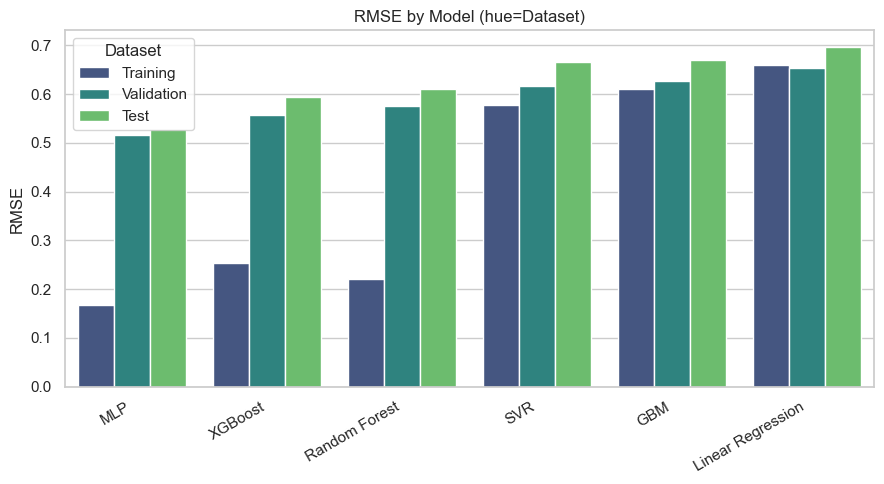

Saved: ../Evaluation_Metrics/figures/bar_MAE_by_Dataset.png


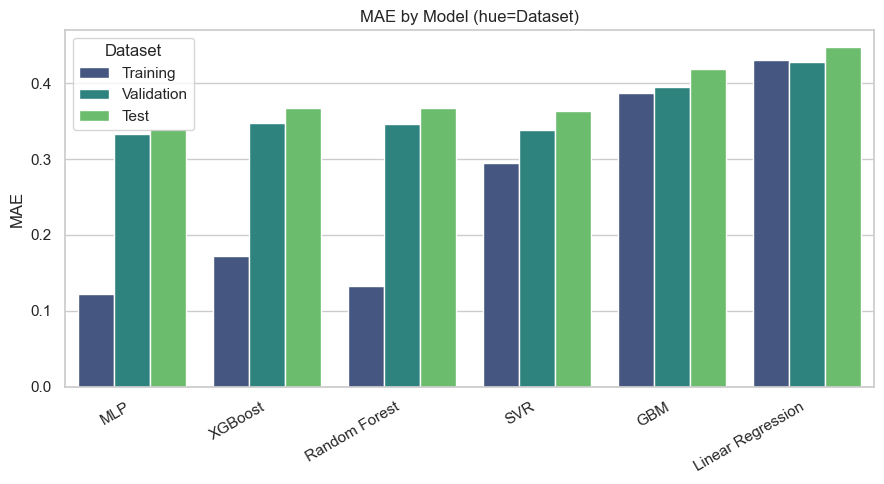

Saved: ../Evaluation_Metrics/figures/bar_R2_by_Dataset.png


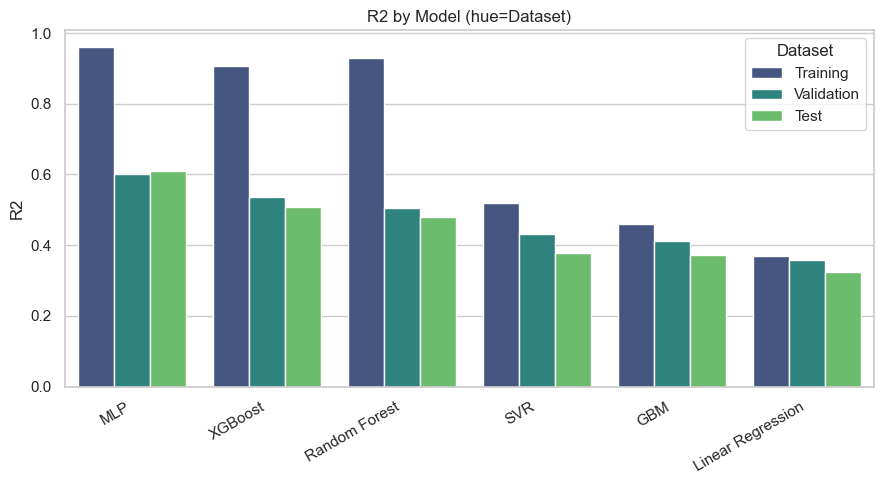

Saved: ../Evaluation_Metrics/figures/bar_MSE_by_Dataset.png


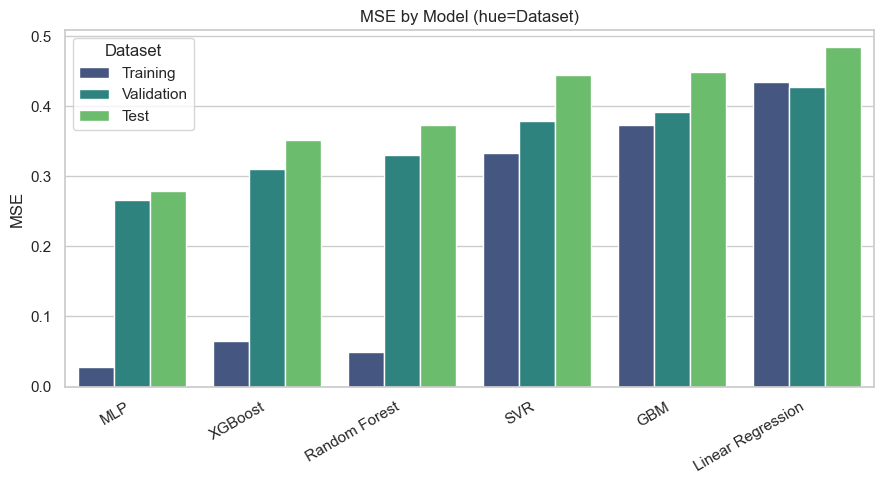

In [4]:
# Helper to draw barplots for each metric

def plot_metric_bars(data, metric, hue=None, order=None, title=None, save=True):
    plt.figure(figsize=(9, 5))
    ax = sns.barplot(
        data=data,
        x="Model",
        y=metric,
        hue=hue,
        order=order,
        estimator="mean",
        errorbar=("ci", 95),
        palette="viridis",
    )
    ax.set_title(title or f"{metric} by Model" + (f" (hue={hue})" if hue else ""))
    ax.set_xlabel("")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    if save:
        out = FIG_DIR / f"bar_{metric.replace(' ', '_')}{'_by_'+hue if hue else ''}.png"
        plt.savefig(out, dpi=150)
        print("Saved:", out)
    plt.show()

# Plot a few common metrics
metrics_to_plot = [m for m in ["RMSE", "MAE", "R2", "MSE"] if m in metric_cols]

for m in metrics_to_plot:
    plot_metric_bars(df, m, hue="Dataset" if has_dataset else None, order=order)

Saved: ../Evaluation_Metrics/figures/heatmap_metric_correlations.png


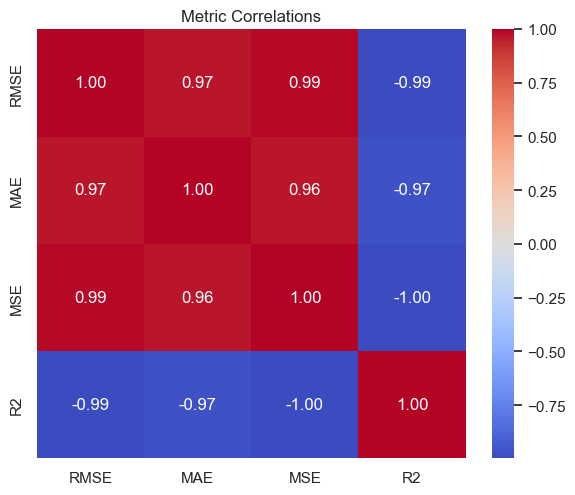

In [5]:
# Heatmap: correlation among metrics (numeric-only)

if len(metric_cols) >= 2:
    corr = df[metric_cols].corr(numeric_only=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Metric Correlations")
    plt.tight_layout()
    out = FIG_DIR / "heatmap_metric_correlations.png"
    plt.savefig(out, dpi=150)
    print("Saved:", out)
    plt.show()

Saved: ../Evaluation_Metrics/figures/pairplot_metrics.png


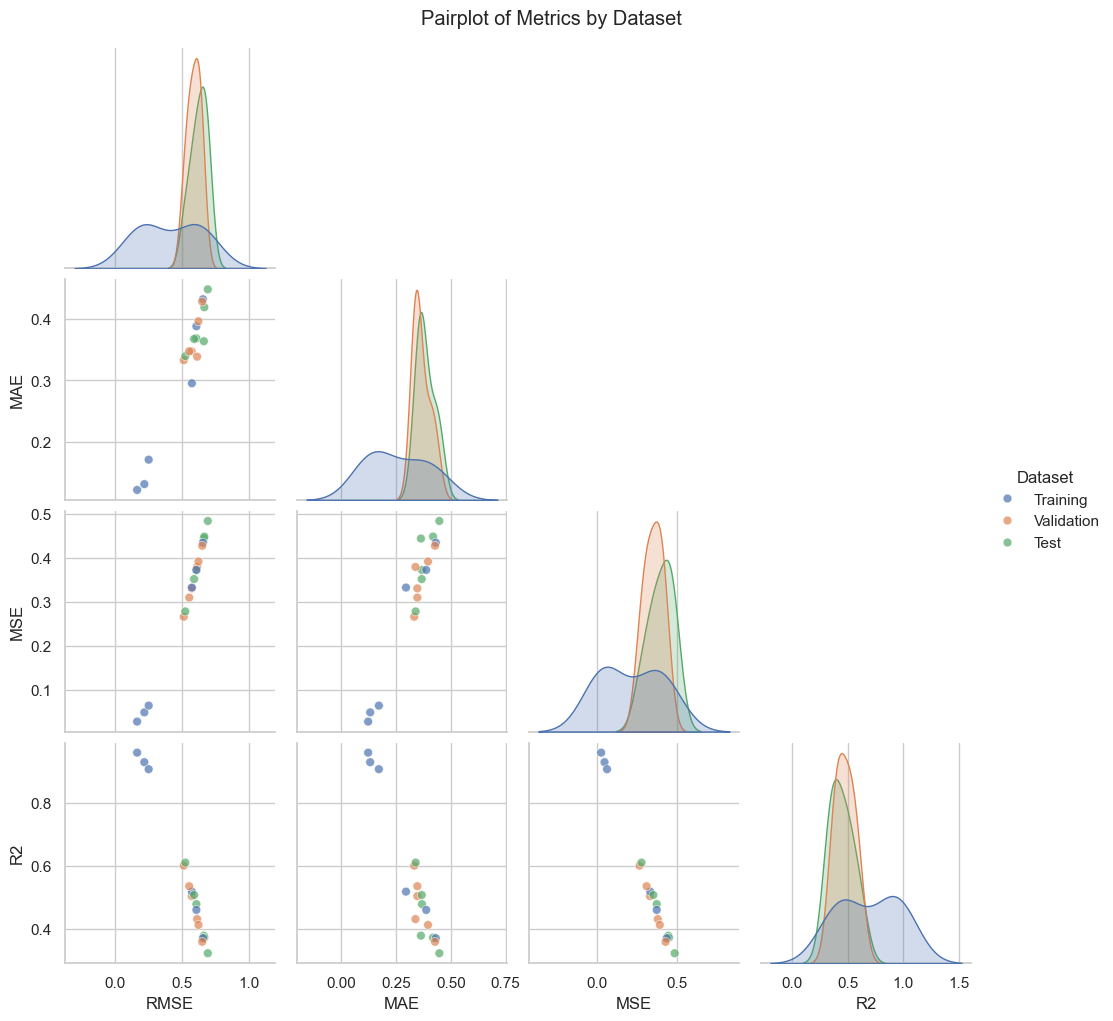

In [6]:
# Pairplot of metrics by model/dataset (optional; can be slow for large data)

pp_cols = metric_cols[:4]  # cap to 4 to keep visuals reasonable
if len(pp_cols) >= 2:
    g = sns.pairplot(
        df,
        vars=pp_cols,
        hue="Dataset" if has_dataset else None,
        corner=True,
        plot_kws=dict(alpha=0.7, s=40),
    )
    g.fig.suptitle("Pairplot of Metrics" + (" by Dataset" if has_dataset else ""), y=1.02)
    out = FIG_DIR / "pairplot_metrics.png"
    g.savefig(out, dpi=150)
    print("Saved:", out)
    plt.show()